# Revert Rate on Indonesian Wikipedia
<hr>

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**

**Last updated on 17 August 2023**

[TASK: T342096](https://phabricator.wikimedia.org/T342096)

# Contents

1. [Overview](#Overview)
2. [Data Gathering](#Data-Gathering)
3. [Analysis](#Analysis)

# Overview

Indonesian Wikipedia will be the one of pilot wikis to test the feasibility of [Automoderator](https://www.mediawiki.org/wiki/Moderator_Tools/Automoderator). The analysis was done to understand the current reversion activity on the project. The following questions have been answered:

* What is the average revert rate by day? (split by namespace and user type)
* What does the distribution of time to revert look like?
* Who are the editors performing reverts? (by user rights and edit bucket)

**Considerations**
- Edits made by bots were not considered.
- Three years of data (July 2020 to June 2023) was considered.

# Data-Gathering

## imports

In [147]:
import wmfdata as wmf
import pandas as pd
import numpy as np

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, FixedLocator

from datetime import timedelta, datetime

pd.options.display.max_columns = None

# spark session

In [2]:
spark_session = wmf.spark.get_active_session()

if type(spark_session) != type(None):
    spark_session.stop()
else:
    print('no active session')

no active session


In [3]:
spark_session = wmf.spark.create_custom_session(
    master="yarn",
    app_name='idwiki-revert-rate',
    spark_config={
        "spark.driver.memory": "4g",
        "spark.dynamicAllocation.maxExecutors": 64,
        "spark.executor.memory": "16g",
        "spark.executor.cores": 4,
        "spark.sql.shuffle.partitions": 256,
        "spark.driver.maxResultSize": "2g"
        
    }
)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/15 12:30:10 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
23/08/15 12:30:10 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
23/08/15 12:30:10 WARN Utils: Service 'sparkDriver' could not bind on port 12001. Attempting port 12002.
23/08/15 12:30:10 WARN Utils: Service 'sparkDriver' could not bind on port 12002. Attempting port 12003.
23/08/15 12:30:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/15 12:30:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/08/15 12:30:10 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/08/15 12:30:18 WARN Utils: Service 'org.apache.spark.netwo

In [4]:
spark_session.sparkContext.setLogLevel("ERROR")

## revert rate query

In [34]:
mw_snapshot = '2023-07'
time_bounds = ['2020-07-01', '2023-06-30'] # three years

In [65]:
%%time

edit_revert_rate_query = """
WITH
    base AS (
        SELECT
            DATE(event_timestamp) AS date,
            CASE
                WHEN event_user_is_anonymous THEN 'anon'
                ELSE 'registered'
            END AS user_type,
            COUNT(DISTINCT revision_id) as edits,
            COUNT(DISTINCT 
                    CASE 
                        WHEN page_namespace_is_content THEN revision_id 
                    END) AS content_edits,
            COUNT(DISTINCT 
                    CASE 
                        WHEN revision_is_identity_reverted THEN revision_id 
                    END) AS reverts,
            COUNT(DISTINCT 
                    CASE 
                        WHEN revision_is_identity_reverted 
                                AND page_namespace_is_content THEN revision_id 
                    END) AS content_reverts
        FROM
            wmf.mediawiki_history
        WHERE
            snapshot = '{MW_SNAPSHOT}' AND
            wiki_db = 'idwiki' AND
            event_entity = 'revision' AND
            event_type = 'create' AND
            DATE(event_timestamp) >= DATE('{START_DATE}') AND
            DATE(event_timestamp) <= DATE('{END_DATE}') AND
            (event_user_is_bot_by IS NULL OR SIZE(event_user_is_bot_by) = 0)
        GROUP BY
            DATE(event_timestamp),
            CASE
                WHEN event_user_is_anonymous THEN 'anon'
                ELSE 'registered'
            END
        )
            
SELECT
    date,
    user_type,
    SUM(edits) AS edits,
    SUM(content_edits) AS content_edits,
    SUM(reverts) AS reverts,
    SUM(content_reverts) AS content_reverts
FROM 
    base
GROUP BY
    date,
    user_type
"""

edit_revert_rate = wmf.spark.run(edit_revert_rate_query.format(START_DATE=time_bounds[0],
                                                               END_DATE=time_bounds[1],
                                                               MW_SNAPSHOT=mw_snapshot))

CPU times: user 379 ms, sys: 46.4 ms, total: 425 ms
Wall time: 1min 42s


## reverts data query

In [107]:
%%time

reverts_data_query = """
WITH 
    base AS (
        SELECT 
            revision_id,
            DATE(event_timestamp) AS date,
            revision_first_identity_reverting_revision_id,
            revision_seconds_to_identity_revert,
            page_namespace_is_content
        FROM 
            wmf.mediawiki_history
        WHERE 
            snapshot = '{MW_SNAPSHOT}' AND
            wiki_db = 'idwiki' AND
            event_entity = 'revision' AND
            event_type = 'create' AND
            revision_is_identity_reverted AND
            DATE (event_timestamp) >= DATE ('{START_DATE}') AND
            DATE (event_timestamp) <= DATE ('{END_DATE}') AND 
            (event_user_is_bot_by IS NULL OR 
             SIZE(event_user_is_bot_by) = 0)
        )
            
SELECT 
    base.*,
    CASE
        WHEN event_user_is_anonymous THEN 'anon'
        ELSE 'registered'
    END AS reverting_editor_type,
    CASE
        WHEN ARRAY_CONTAINS(event_user_groups, 'bot') THEN 'bot'
        WHEN NOT ARRAY_CONTAINS(event_user_groups, 'bot') AND 
                    ARRAY_CONTAINS(event_user_groups, 'sysop') THEN 'admin'
        WHEN NOT ARRAY_CONTAINS(event_user_groups, 'bot') AND 
                    ARRAY_CONTAINS(event_user_groups, 'rollbacker') THEN 'rollbacker'
        ELSE 'others'
    END AS reverting_editor_rights,
    CASE
        WHEN event_user_revision_count >= 0 AND event_user_revision_count < 100 THEN '0-99'
        WHEN event_user_revision_count >= 100 AND event_user_revision_count < 500 THEN '100-499'
        WHEN event_user_revision_count >= 500 THEN '500+'
        ELSE 'n/a'
    END AS edit_bucket,
    revision_is_identity_reverted AS revert_is_reverted,
    event_user_text AS reverting_editor
FROM 
    base
JOIN wmf.mediawiki_history mwh
     ON base.revision_first_identity_reverting_revision_id = mwh.revision_id
WHERE
    snapshot = '{MW_SNAPSHOT}' AND 
    wiki_db = 'idwiki' AND 
    event_entity = 'revision' AND 
    event_type = 'create'
"""

reverts = wmf.spark.run(reverts_data_query.format(START_DATE=time_bounds[0],
                                                 END_DATE=time_bounds[1],
                                                 MW_SNAPSHOT=mw_snapshot))

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


CPU times: user 3.8 s, sys: 278 ms, total: 4.08 s
Wall time: 3min 51s


# Analysis

## Edit Revert Rate

In [109]:
edit_revert_rate_grouped = round(edit_revert_rate
                                 .groupby(['date', 'user_type'])
                                 .mean()
                                 .groupby('user_type')
                                 .mean())

edit_revert_rate_grouped

,edits,content_edits,reverts,content_reverts
user_type,,,,
anon,612.0,583.0,162.0,151.0
registered,2974.0,2385.0,177.0,127.0


In [211]:
wmf.utils.df_to_remarkup(edit_revert_rate_grouped.reset_index())

| user_type | edits | content_edits | reverts | content_reverts
| ----- | ----- | ----- | ----- | ----- 
| anon | 612.0 | 583.0 | 162.0 | 151.0
| registered | 2974.0 | 2385.0 | 177.0 | 127.0



In [119]:
# edits performed by anonymous editors
anon_edits_revert_rate = edit_revert_rate_grouped.loc['anon', 'reverts'] / edit_revert_rate_grouped.loc['anon', 'edits'] * 100
anon_content_edits_revert_rate = edit_revert_rate_grouped.loc['anon', 'content_reverts'] / edit_revert_rate_grouped.loc['anon', 'content_edits'] * 100

# edits performed by registered editors
registered_edits_revert_rate = edit_revert_rate_grouped.loc['registered', 'reverts'] / edit_revert_rate_grouped.loc['registered', 'edits'] * 100
registered_content_edits_revert_rate = edit_revert_rate_grouped.loc['registered', 'content_reverts'] / edit_revert_rate_grouped.loc['registered', 'content_edits'] * 100

In [127]:
print(f'On average per day,\
    \n\t{round(anon_edits_revert_rate, 2)}% of edits made by anonymous editors were reverted\
    \n\t{round(anon_content_edits_revert_rate, 2)}% of content edits made by anonymous editors were reverted\
    \n\t{round(registered_edits_revert_rate, 2)}% of edits made by registered editors were reverted\
    \n\t{round(registered_content_edits_revert_rate, 2)}% of content edits made by registered editors were reverted')

On average per day,    
	26.47% of edits made by anonymous editors were reverted    
	25.9% of content edits made by anonymous editors were reverted    
	5.95% of edits made by registered editors were reverted    
	5.32% of content edits made by registered editors were reverted


## Distribution of Time to Revert

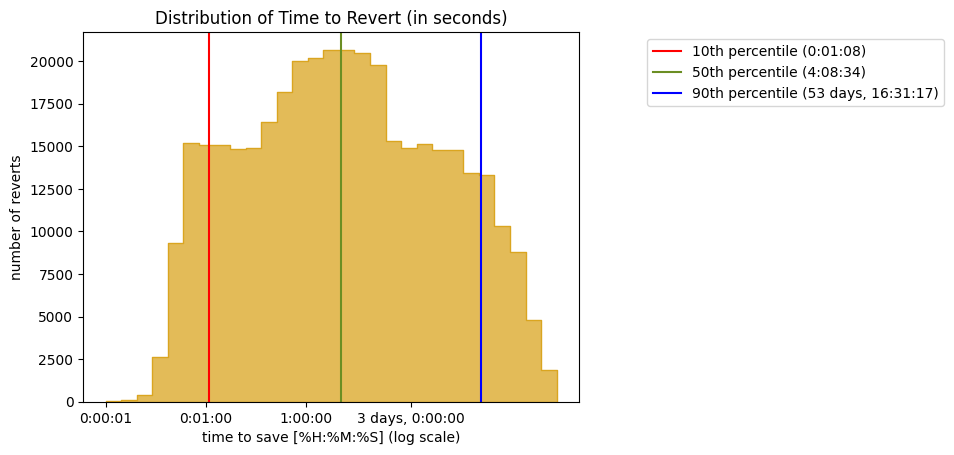

In [199]:
def generate_hist(ax, frame, title, 
                  col='revision_seconds_to_identity_revert', 
                  ylabel='number of reverts', 
                  legend_loc='upper right', 
                  anchor_pos=(1.75, 1)):
    
    ax = sns.histplot(data=frame, 
                      x=col, 
                      log_scale=True,
                      bins = np.linspace(0, 8, 30), 
                      element='step',
                      color='#DAA520'
                 )
    
    def td_str(s):
        return str(timedelta(seconds=int(s)))
    
    x_ticks = [1, 60, 1*60*60, 3*24*60*60]
    duration_ticks = FixedLocator(x_ticks)
    duration_fmt = FuncFormatter(lambda x, pos: td_str(x))
    
    lines = [
        ("10th percentile ({})", frame[col].quantile(0.1), "#FF0000"),
        ("50th percentile ({})", frame[col].median(), "#6B8E23"),
        ("90th percentile ({})", frame[col].quantile(0.9), "#0000FF")
    ]
    
    for label, pos, color in lines:
        ax.axvline(x=pos, color=color, label=label.format(td_str(pos)))
    
    ax.xaxis.set_major_locator(duration_ticks)
    ax.xaxis.set_major_formatter(duration_fmt)
    
    ax.set_title(title)
    ax.set_xlabel('time to save [%H:%M:%S] (log scale)')
    ax.set_ylabel(ylabel)
    
    ax.legend(loc=legend_loc, bbox_to_anchor=anchor_pos)
    
fig, ax = plt.subplots()
generate_hist(ax, reverts.query("""revision_seconds_to_identity_revert != 0"""), 
              title='Distribution of Time to Revert (in seconds)')

In [209]:
def quantiles(frame, col='revision_seconds_to_identity_revert'):    

    qdict = {
        '10th': frame[col].quantile(0.1)/60,
        '25th': frame[col].quantile(0.25)/60,
        '50th': frame[col].quantile(0.5)/60,
        '75th': frame[col].quantile(0.75)/60,
        '90th': frame[col].quantile(0.9)/60,
        '99th': frame[col].quantile(0.99)/60
    }
    
    df = pd.DataFrame(qdict.values(),
                      index=qdict.keys(),
                      columns=['time (in minutes)'])
    
    df = df.astype({'time (in minutes)': int})
    df.index.name = 'percentile'
    
    return df

In [214]:
time_to_revert_quantiles = quantiles(reverts.query("""revision_seconds_to_identity_revert != 0"""))
time_to_revert_quantiles['time (in hours)'] = round(time_to_revert_quantiles['time (in minutes)'] / 60, 3)
time_to_revert_quantiles

,time (in minutes),time (in hours)
percentile,,
10th,1,0.017
25th,11,0.183
50th,248,4.133
75th,6627,110.450
90th,77311,1288.517
99th,682231,11370.517


## Reverting Editors by User Right

In [219]:
wmf.utils.df_to_remarkup(round((reverts
       .groupby(['date', 'reverting_editor_type', 'reverting_editor_rights'])
       .agg({
           'revision_id': 'count'
       })
      )
      .groupby(['reverting_editor_type', 'reverting_editor_rights'])
      .mean()).reset_index())

| reverting_editor_type | reverting_editor_rights | revision_id
| ----- | ----- | ----- 
| anon | others | 40.0
| registered | admin | 102.0
| registered | bot | 8.0
| registered | others | 133.0
| registered | rollbacker | 57.0



In [223]:
(reverts.query("""(reverting_editor_rights == 'others') & (reverting_editor_type == 'registered') & (edit_bucket != 'n/a')""") 
 .groupby('edit_bucket')
 .agg({
     'revision_id': 'count'
 })
 .sort_values('revision_id', 
              ascending=False)
 .rename({
     'revision_id': 'total_reverts_(3 years)'
 }, axis=1)
)

,total_reverts_(3 years)
edit_bucket,
500+,105595
0-99,22809
100-499,14307


## Bots Performing Reverts

In [144]:
(reverts
 .query("""reverting_editor_rights == 'bot'""")
 .groupby('reverting_editor')
 .agg({
     'revision_id': 'count'
 })
 .sort_values('revision_id', 
              ascending=False)
 .rename({
     'revision_id': 'total_reverts_(3 years)'
 }, axis=1)
)

,total_reverts_(3 years)
reverting_editor,
HsfBot,3819
AABot,1843
EmausBot,727
Arya-Bot,619
Xqbot,326
Wagino Bot,36
Bot5958,35
InternetArchiveBot,21
OrophinBot,16
